In [2]:
# Import every package we need

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import prim, dimensional_stacking, cart
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\newbi\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [3]:
# Load in self-created visualization functions
from visualization_functions import histogram_maker, mean_outcomes, aggregate_outcomes, scatter_maker, pairplot_maker, boxplot_histogram_maker, boxplot_maker

In [ ]:
import pickle

results_MORO, convergence = pickle.load(open('Outcomes/MORO_s50_nfe20000.pkl', 'rb'))

In [ ]:
# Initialize model parameters
from model.dike_model_function import DikeNetwork  # @UnresolvedImport
from model.problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(5)

In [ ]:
results_MORO

In [ ]:
policies = []
for row in range(results_MORO.shape[0]):
    policies.append(
        Policy(name = row, **results_MORO.iloc[row,:-5].to_dict())  # Do not include the damage scores
    )

In [19]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=400,policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 400 scenarios * 9 policies * 1 model(s) = 3600 experiments
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2520 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3240 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [20]:
from ema_workbench.util.utilities import (save_results, load_results)

save_results(results, "Outcomes/MOROpolicies400Scenarios.csv" )

[MainProcess/INFO] results saved successfully to /Users/jrwang/Documents/Coding/Model-based-decision-making/Outcomes/MOROpolicies400Scenarios.csv


In [4]:
from ema_workbench.util.utilities import (save_results, load_results)

results = load_results('Outcomes/MOROpolicies400Scenarios.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")
# results = results.apply(pd.to_numeric)
results.head()

[MainProcess/INFO] results loaded succesfully from /Users/jrwang/Documents/Coding/Model-based-decision-making/Outcomes/MOROpolicies400Scenarios.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,16.0,95.366886,1.0,0.334887,278.890461,10.0,0.602767,173.139661,1.5,0.364909,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
1,20.0,311.236496,1.5,0.648404,102.259704,1.0,0.888705,84.422554,1.5,0.359334,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
2,102.0,300.059210,1.0,0.449451,111.094021,1.5,0.935721,208.285945,10.0,0.006956,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
3,69.0,128.702886,10.0,0.595469,119.355882,1.0,0.872678,146.418145,1.0,0.685500,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
4,44.0,278.386091,10.0,0.190867,149.400545,1.0,0.153690,335.927277,1.5,0.905726,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0


In [5]:
aggregate_outcomes(results, "Expected Annual Damage")
aggregate_outcomes(results, "Expected Number of Deaths")

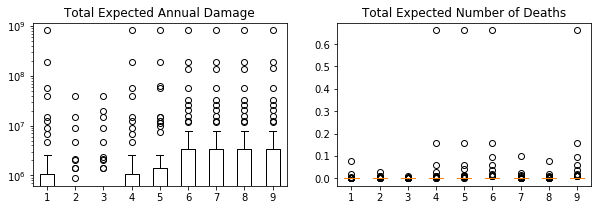

In [6]:
total_outcomes = ["Total Expected Annual Damage", "Total Expected Number of Deaths"]

boxplot_maker(results, total_outcomes)

In [ ]:
histogram_maker(results, "Expected Annual Damage")
histogram_maker(results, "Expected Number of Deaths")

In [ ]:
mean_outcomes(results)

Caution when looking at the plots, because the legend is not fixed! 

In [ ]:
scatter_maker(results, "Expected Annual Damage")
scatter_maker(results, "Expected Number of Deaths")

In [ ]:
pairplot_maker(results, "A.2")

## Scenario Discovery

In [ ]:
aggregate_outcomes(results, "Expected Number of Deaths")
aggregate_outcomes(results, "Expected Annual Damage")

In [ ]:
boxplot_histogram_maker(results)

In [ ]:
x = results.iloc[:, :19] # Only take the uncertentainties 

y_deaths = results['Total Expected Number of Deaths'].values
y_deaths = y_deaths > np.percentile(y_deaths, 95)

In [ ]:
prim_alg = prim.Prim(x, y_deaths, threshold=0.55, peel_alpha=0.005)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

## Further investigation on specific locations

Check A.1 as well..

Further discovery of location A2 and time step 1 as the scatter plots and histograms showed that the policies are not robust yet. 

In [ ]:
y_deaths_A1 = results["A.1_Expected Number of Deaths 0"]
y_deaths_A1 = y_deaths_A1 > np.percentile(y_deaths_A1, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [ ]:
y_damages_A1 = results["A.1_Expected Annual Damage 0"]
y_damages_A1 = y_damages_A1 > np.percentile(y_damages_A1, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

## A.2

In [ ]:
# A.2_Expected Annual Damage 0
# A.2_Expected Number of Deaths 0

y_deaths_A2 = results["A.2_Expected Number of Deaths 0"]
y_deaths_A2 = y_deaths_A2 > np.percentile(y_deaths_A2, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A2, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [ ]:
y_damages_A2 = results["A.2_Expected Annual Damage 0"]
y_damages_A2 = y_damages_A2 > np.percentile(y_damages_A2, 90)

In [ ]:
prim_alg = prim.Prim(x, y_damages_A2, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
# PCA: same coverage

# x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
# x_categorical = x.select_dtypes(include=pd.CategoricalDtype)

# rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, y_damages_A2)

# rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)

# prim_obj = prim.Prim(rotated_x, y_damages_A2, threshold=0.1, peel_alpha=0.1)
# box1 = prim_obj.find_box()

# box1.show_tradeoff()
# plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()